In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.image as mpimg

In [58]:
# File loading

DIR = "/content/drive/MyDrive/ML_project/data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
print("Images: " + str(len(df.index)) + ", classes: " + str(len(df.groupby(['category']).count())) + ", super classes: " + str(len(df.groupby(['super_category']).count())))

Images: 6739, classes: 20, super classes: 19


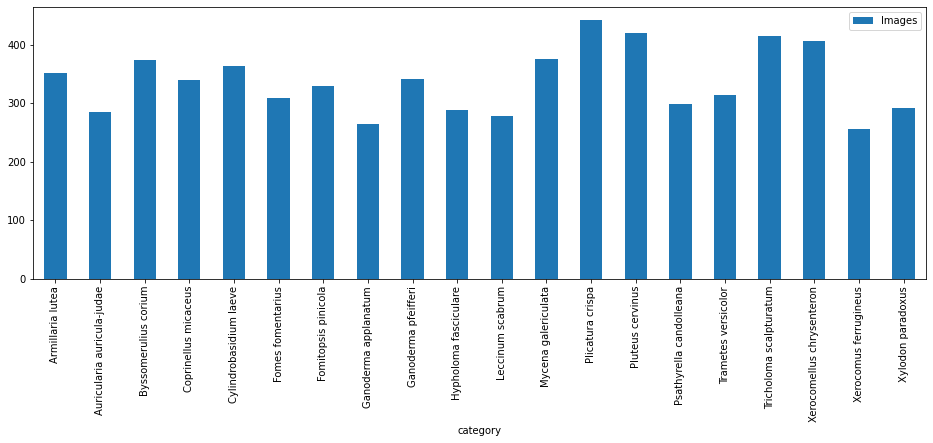

In [59]:
df_grouped = df.groupby(['category']).count().rename(columns={'path':'count'})[['count']]
fig, ax = plt.subplots()
df_grouped.plot(ax=ax, kind='bar', figsize=(16,5))
ax.legend(["Images"])
plt.show()

df_sorted = df_grouped.sort_values(by='count', ascending=False)

In [60]:
# Global parameters

n_classes = 3
samples_per_class = 100
training_size_ratio = 0.8
IMG_SIZE = (224, 224)
validation_size_ratio = 0.2
batch_size = 32             # if None is 32 (default)
learning_rate = 0.001
patience = 10

In [61]:
reference = 'category'
#n_classes = df_sorted.shape[0]

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:n_classes].iterrows():
    size = min(samples_per_class, df.loc[df[reference] == i].shape[0])
    training_size = int(size*training_size_ratio)
    validation_size = int(training_size*validation_size_ratio)

    tmp_df = df.loc[df[reference] == i].iloc[:training_size-validation_size]
    tmp_df['split'] = 'train'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size-validation_size:training_size]
    tmp_df['split'] = 'val'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size:samples_per_class]
    tmp_df['split'] = 'test'
    df1 = df1.append(tmp_df)

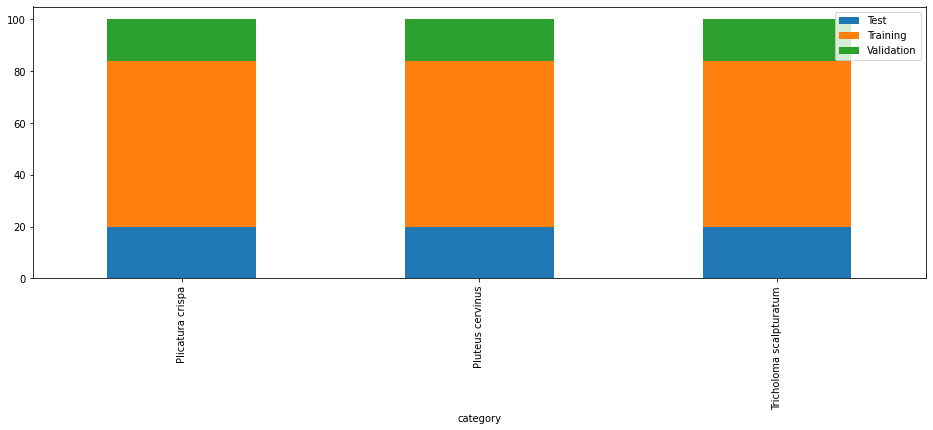

In [62]:
df_count = df1.groupby(['category','split']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('split')
fig, ax = plt.subplots()
df_count.plot(kind='bar', ax=ax, stacked=True, figsize=(16,5))
ax.legend(["Test", "Training", "Validation"])

In [63]:
df_training = df1.loc[df1['split'] == 'train']
df_validation = df1.loc[df1['split'] == 'val']
df_test = df1.loc[df1['split'] == 'test']

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])
print("Test set:", df_test.shape[0])

Training set: 192
Validation set: 48
Test set: 60


In [64]:
DIR = os.getcwd()

training_datagen = ImageDataGenerator()

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 192 validated image filenames belonging to 3 classes.


In [65]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 48 validated image filenames belonging to 3 classes.


In [66]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical',
    shuffle=False
)

Found 60 validated image filenames belonging to 3 classes.


In [67]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

In [68]:
# From https://www.tensorflow.org/tutorials/images/transfer_learning

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [69]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [70]:
base_model.trainable = False

In [71]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=n_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [72]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_4 True
sequential_1 True
tf.math.truediv_1 True
tf.math.subtract_1 True
mobilenetv2_1.00_224 False
global_average_pooling2d_1 True
dropout_1 True
dense_1 True


In [73]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [74]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy','top_k_categorical_accuracy'])

In [75]:
def elapsed_time(start_time):
    delta = time.time()-start_time
    hours = int(delta/(60*60))
    delta -= hours*(60*60)
    minut = int(delta/60)
    delta -= minut*60
    sec = int(delta)
    return (hours, minut, sec)

In [76]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start_time = time.time()

history = model.fit(train_generator, epochs=100, batch_size=batch_size,
            validation_data = validation_generator,
            verbose=1, callbacks=[early_stopping])

training_time = elapsed_time(start_time)
print("Elapsed time: %ih %im %is" % training_time)

#model.load_weights(checkpoint_filepath)
#model.save('/content/drive/MyDrive/ML_project/model.h5')

Epoch 1/100
6/6 [==============================] - 148s 25s/step - loss: 1.5072 - accuracy: 0.3481 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.1202 - val_accuracy: 0.4167 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/100
6/6 [==============================] - 2s 404ms/step - loss: 1.0006 - accuracy: 0.5262 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8941 - val_accuracy: 0.5833 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/100
6/6 [==============================] - 2s 403ms/step - loss: 0.7663 - accuracy: 0.6906 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8182 - val_accuracy: 0.6042 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/100
6/6 [==============================] - 2s 402ms/step - loss: 0.5818 - accuracy: 0.7440 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7272 - val_accuracy: 0.6250 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/100
6/6 [==============================] - 2s 404ms/step - loss: 0.5046 - accuracy: 0.8062 - top_k_categorical_accur

In [77]:
def plot_learning_curves(history, history_fine=False):

  if history_fine:
    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']
    start_fine_tuning = len(history.history['accuracy'])
  else:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']


  fig, axes = plt.subplots(1, 2, figsize=(16,5))

  # summarize history for accuracy
  axes[0].plot(acc, label='Training Accuracy')
  axes[0].plot(val_acc, label='Validation Accuracy')
  if history_fine:
    axes[0].plot([start_fine_tuning-1, start_fine_tuning-1], plt.ylim(), label='Start Fine Tuning')
  axes[0].set_title('Model accuracy')
  axes[0].set_ylabel('Accuracy')
  axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
  axes[0].set_xlabel('Epoch')
  axes[0].legend(loc='lower right')

  # summarize history for loss
  axes[1].plot(loss, label='Training Loss')
  axes[1].plot(val_loss, label='Validation Loss')
  if history_fine:
    axes[1].plot([start_fine_tuning-1, start_fine_tuning-1], plt.ylim(), label='Start Fine Tuning')
  axes[1].set_title('Model loss')
  axes[1].set_ylabel('Loss')
  axes[1].set_xlabel('Epoch')
  axes[1].legend(loc='upper right')

  plt.show()

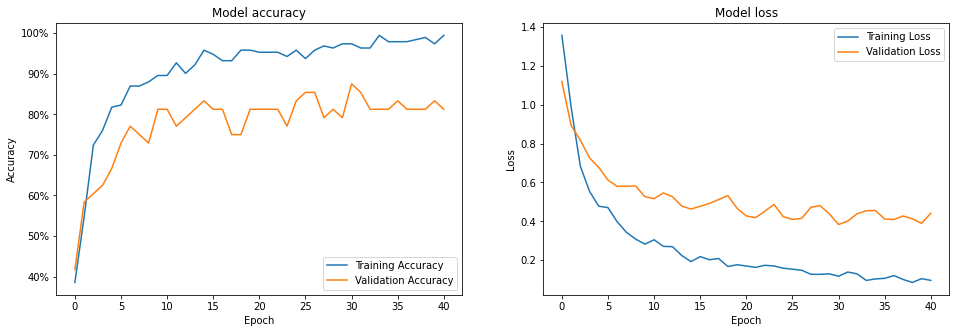

In [78]:
plot_learning_curves(history)

In [79]:
test_loss, test_acc, _ = model.evaluate(test_generator)

2/2 [==============================] - 20s 19s/step - loss: 0.5637 - accuracy: 0.7333 - top_k_categorical_accuracy: 1.0000


In [80]:
def print_classification_report_and_confusion_matrix():
  #Confution Matrix and Classification Report
  Y_pred = model.predict(test_generator, df_test.shape[0] // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('Classification Report')
  print(classification_report(test_generator.classes, y_pred, target_names=classes))

  df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_pred), 
                      index = [i for i in classes],
                      columns = [i for i in classes])
  plt = sn.heatmap(df_cm, annot=True, cmap="Blues")
  plt.set_ylabel("Real") 
  plt.set_xlabel("Predicted")
  plt.set_xticklabels(plt.get_xticklabels(), rotation=-30, ha="left") 

Classification Report
                         precision    recall  f1-score   support

       Plicatura crispa       0.93      0.65      0.76        20
       Pluteus cervinus       0.68      0.85      0.76        20
Tricholoma scalpturatum       0.67      0.70      0.68        20

               accuracy                           0.73        60
              macro avg       0.76      0.73      0.73        60
           weighted avg       0.76      0.73      0.73        60



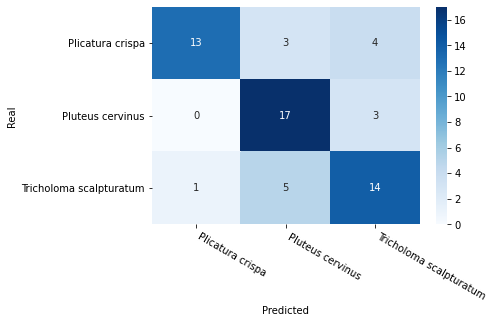

In [81]:
print_classification_report_and_confusion_matrix()

In [82]:
# Fine tuning

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [83]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [84]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [85]:
start_time = time.time()

history_fine = model.fit(train_generator, 
                    epochs=len(history.history['accuracy']) + 20,
                    initial_epoch=history.epoch[-1],
                    batch_size=batch_size,
                    validation_data = validation_generator,
                    verbose=1, 
                    callbacks=[early_stopping])

training_time = elapsed_time(start_time)
print("\nElapsed time: %ih %im %is" % training_time)

Epoch 41/61
6/6 [==============================] - 7s 647ms/step - loss: 0.2377 - accuracy: 0.9101 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6020 - val_accuracy: 0.7708 - val_top_k_categorical_accuracy: 1.0000
Epoch 42/61
6/6 [==============================] - 2s 411ms/step - loss: 0.0626 - accuracy: 0.9864 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8681 - val_accuracy: 0.7292 - val_top_k_categorical_accuracy: 1.0000
Epoch 43/61
6/6 [==============================] - 2s 407ms/step - loss: 0.0551 - accuracy: 0.9930 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7433 - val_accuracy: 0.7083 - val_top_k_categorical_accuracy: 1.0000
Epoch 44/61
6/6 [==============================] - 2s 407ms/step - loss: 0.0807 - accuracy: 0.9769 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7136 - val_accuracy: 0.7292 - val_top_k_categorical_accuracy: 1.0000
Epoch 45/61
6/6 [==============================] - 2s 406ms/step - loss: 0.0505 - accuracy: 0.9883 - top_k_categorical_accur

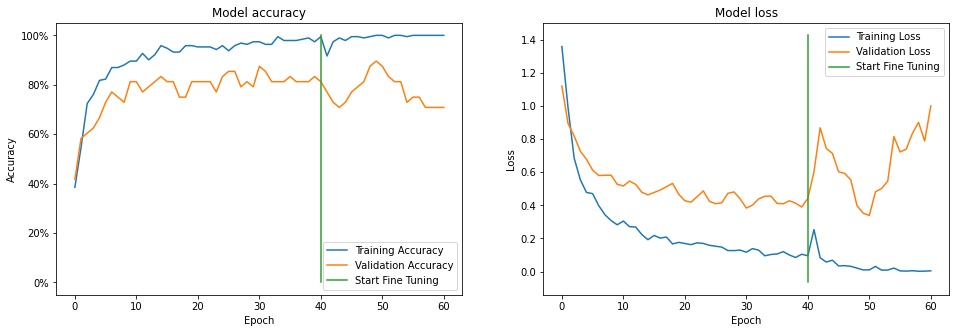

In [86]:
plot_learning_curves(history, history_fine)

In [87]:
test_loss, test_acc, _ = model.evaluate(test_generator)

2/2 [==============================] - 1s 266ms/step - loss: 0.9335 - accuracy: 0.7167 - top_k_categorical_accuracy: 1.0000


Classification Report
                         precision    recall  f1-score   support

       Plicatura crispa       1.00      0.50      0.67        20
       Pluteus cervinus       0.60      0.90      0.72        20
Tricholoma scalpturatum       0.75      0.75      0.75        20

               accuracy                           0.72        60
              macro avg       0.78      0.72      0.71        60
           weighted avg       0.78      0.72      0.71        60



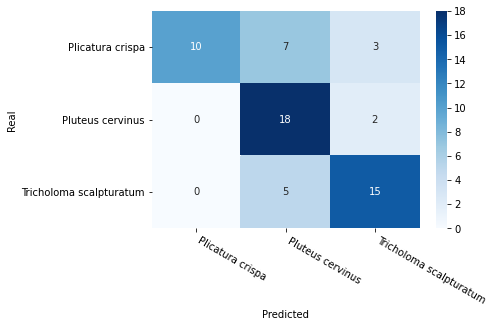

In [88]:
print_classification_report_and_confusion_matrix()

Found 60 validated image filenames belonging to 3 classes.


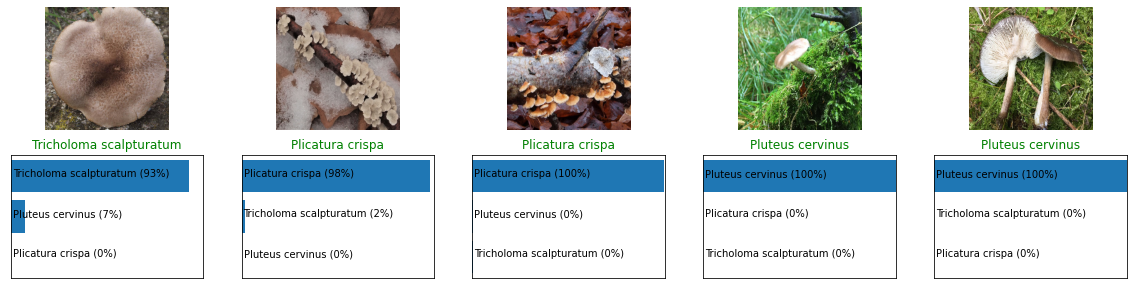

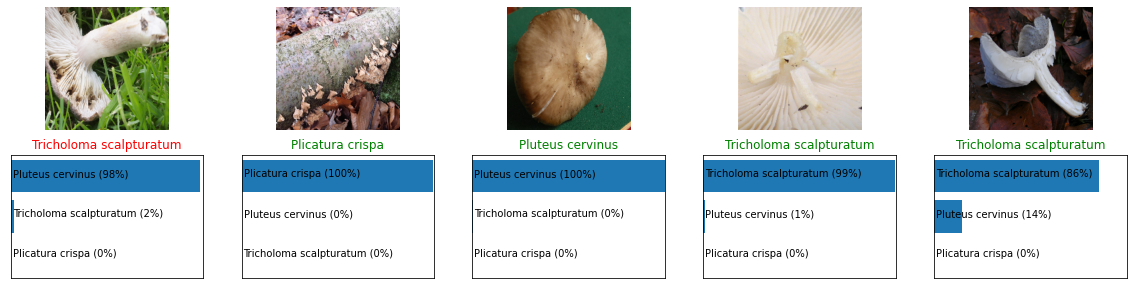

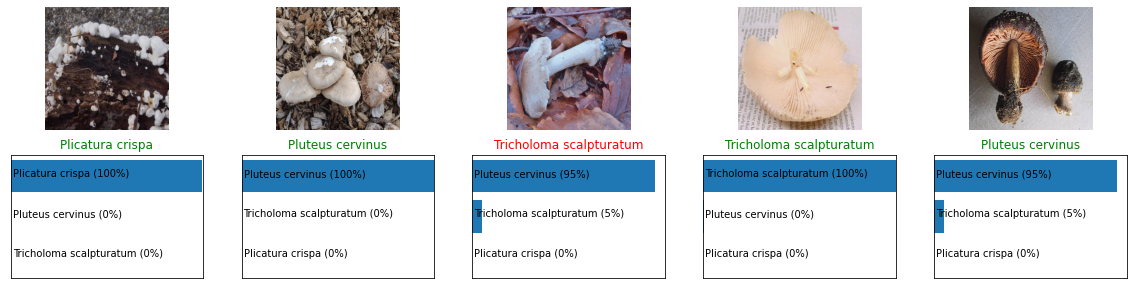

In [114]:
# Making some random predicions

# Shuffle the generator to obtain random images
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

iters = 0
n_predictions = 12
n_cols = 5
    
for i, batch in enumerate(test_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(20,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k].astype(np.uint8))
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()